Using device: cuda


/tmp/ipykernel_36/1977902460.py:134: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset('/kaggle/input/pr1-rbc-sim-data/RBC_Output.nc')


Input tensor shape: torch.Size([1, 4, 256, 256])
Target tensor shape: torch.Size([1, 4, 256, 256])
Total parameters in FNO: 33,592,900

Starting training with dynamic configuration...
Epoch 0/1600 | Total: 12342.375000 | Physics: 1.310484 | Data: 1233.421143
Epoch 100/1600 | Total: 9087.759766 | Physics: 1.310709 | Data: 907.962463
Epoch 200/1600 | Total: 50.911060 | Physics: 1.258279 | Data: 4.502503
Epoch 300/1600 | Total: 9.166534 | Physics: 1.276969 | Data: 0.390055
Epoch 400/1600 | Total: 6.707877 | Physics: 1.267527 | Data: 0.155155
Epoch 500/1600 | Total: 6.019057 | Physics: 1.266866 | Data: 0.086166
Epoch 600/1600 | Total: 6.239296 | Physics: 1.266307 | Data: 0.110921
Epoch 700/1600 | Total: 5.802303 | Physics: 1.265860 | Data: 0.066098
Epoch 800/1600 | Total: 5.690857 | Physics: 1.265071 | Data: 0.054298
Epoch 900/1600 | Total: 5.716673 | Physics: 1.266195 | Data: 0.057112
Epoch 1000/1600 | Total: 5.588471 | Physics: 1.265528 | Data: 0.043868
Epoch 1100/1600 | Total: 5.542814 

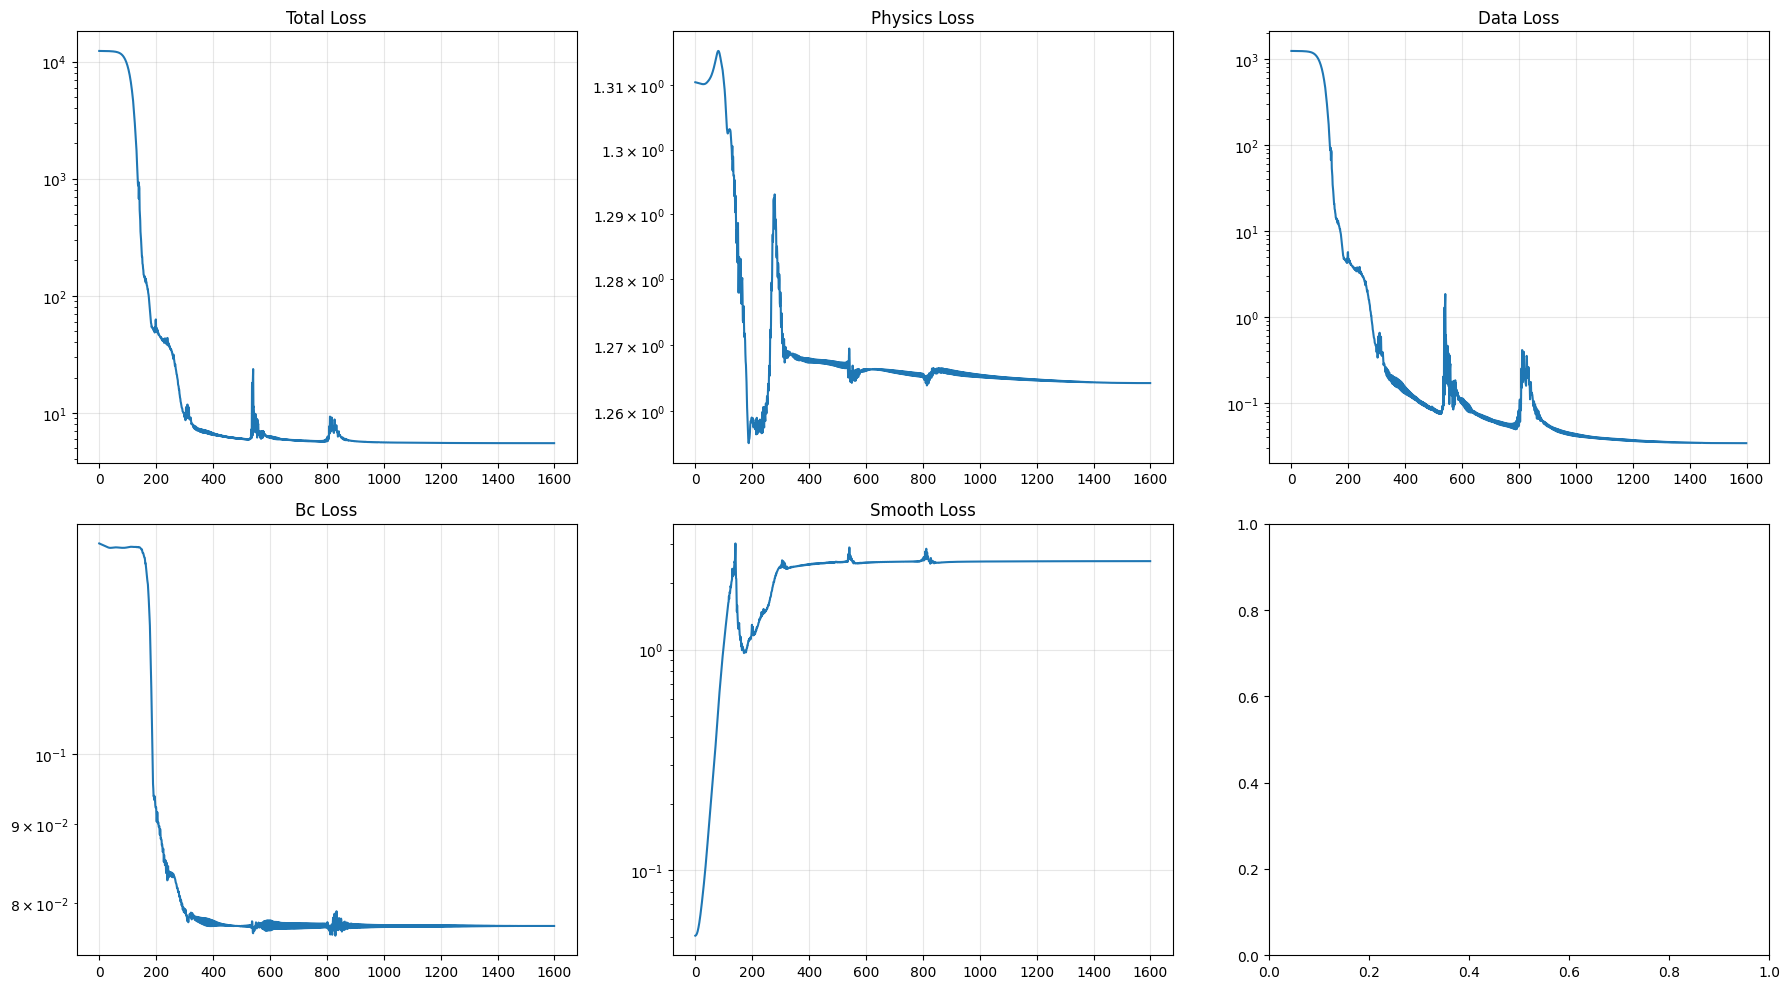

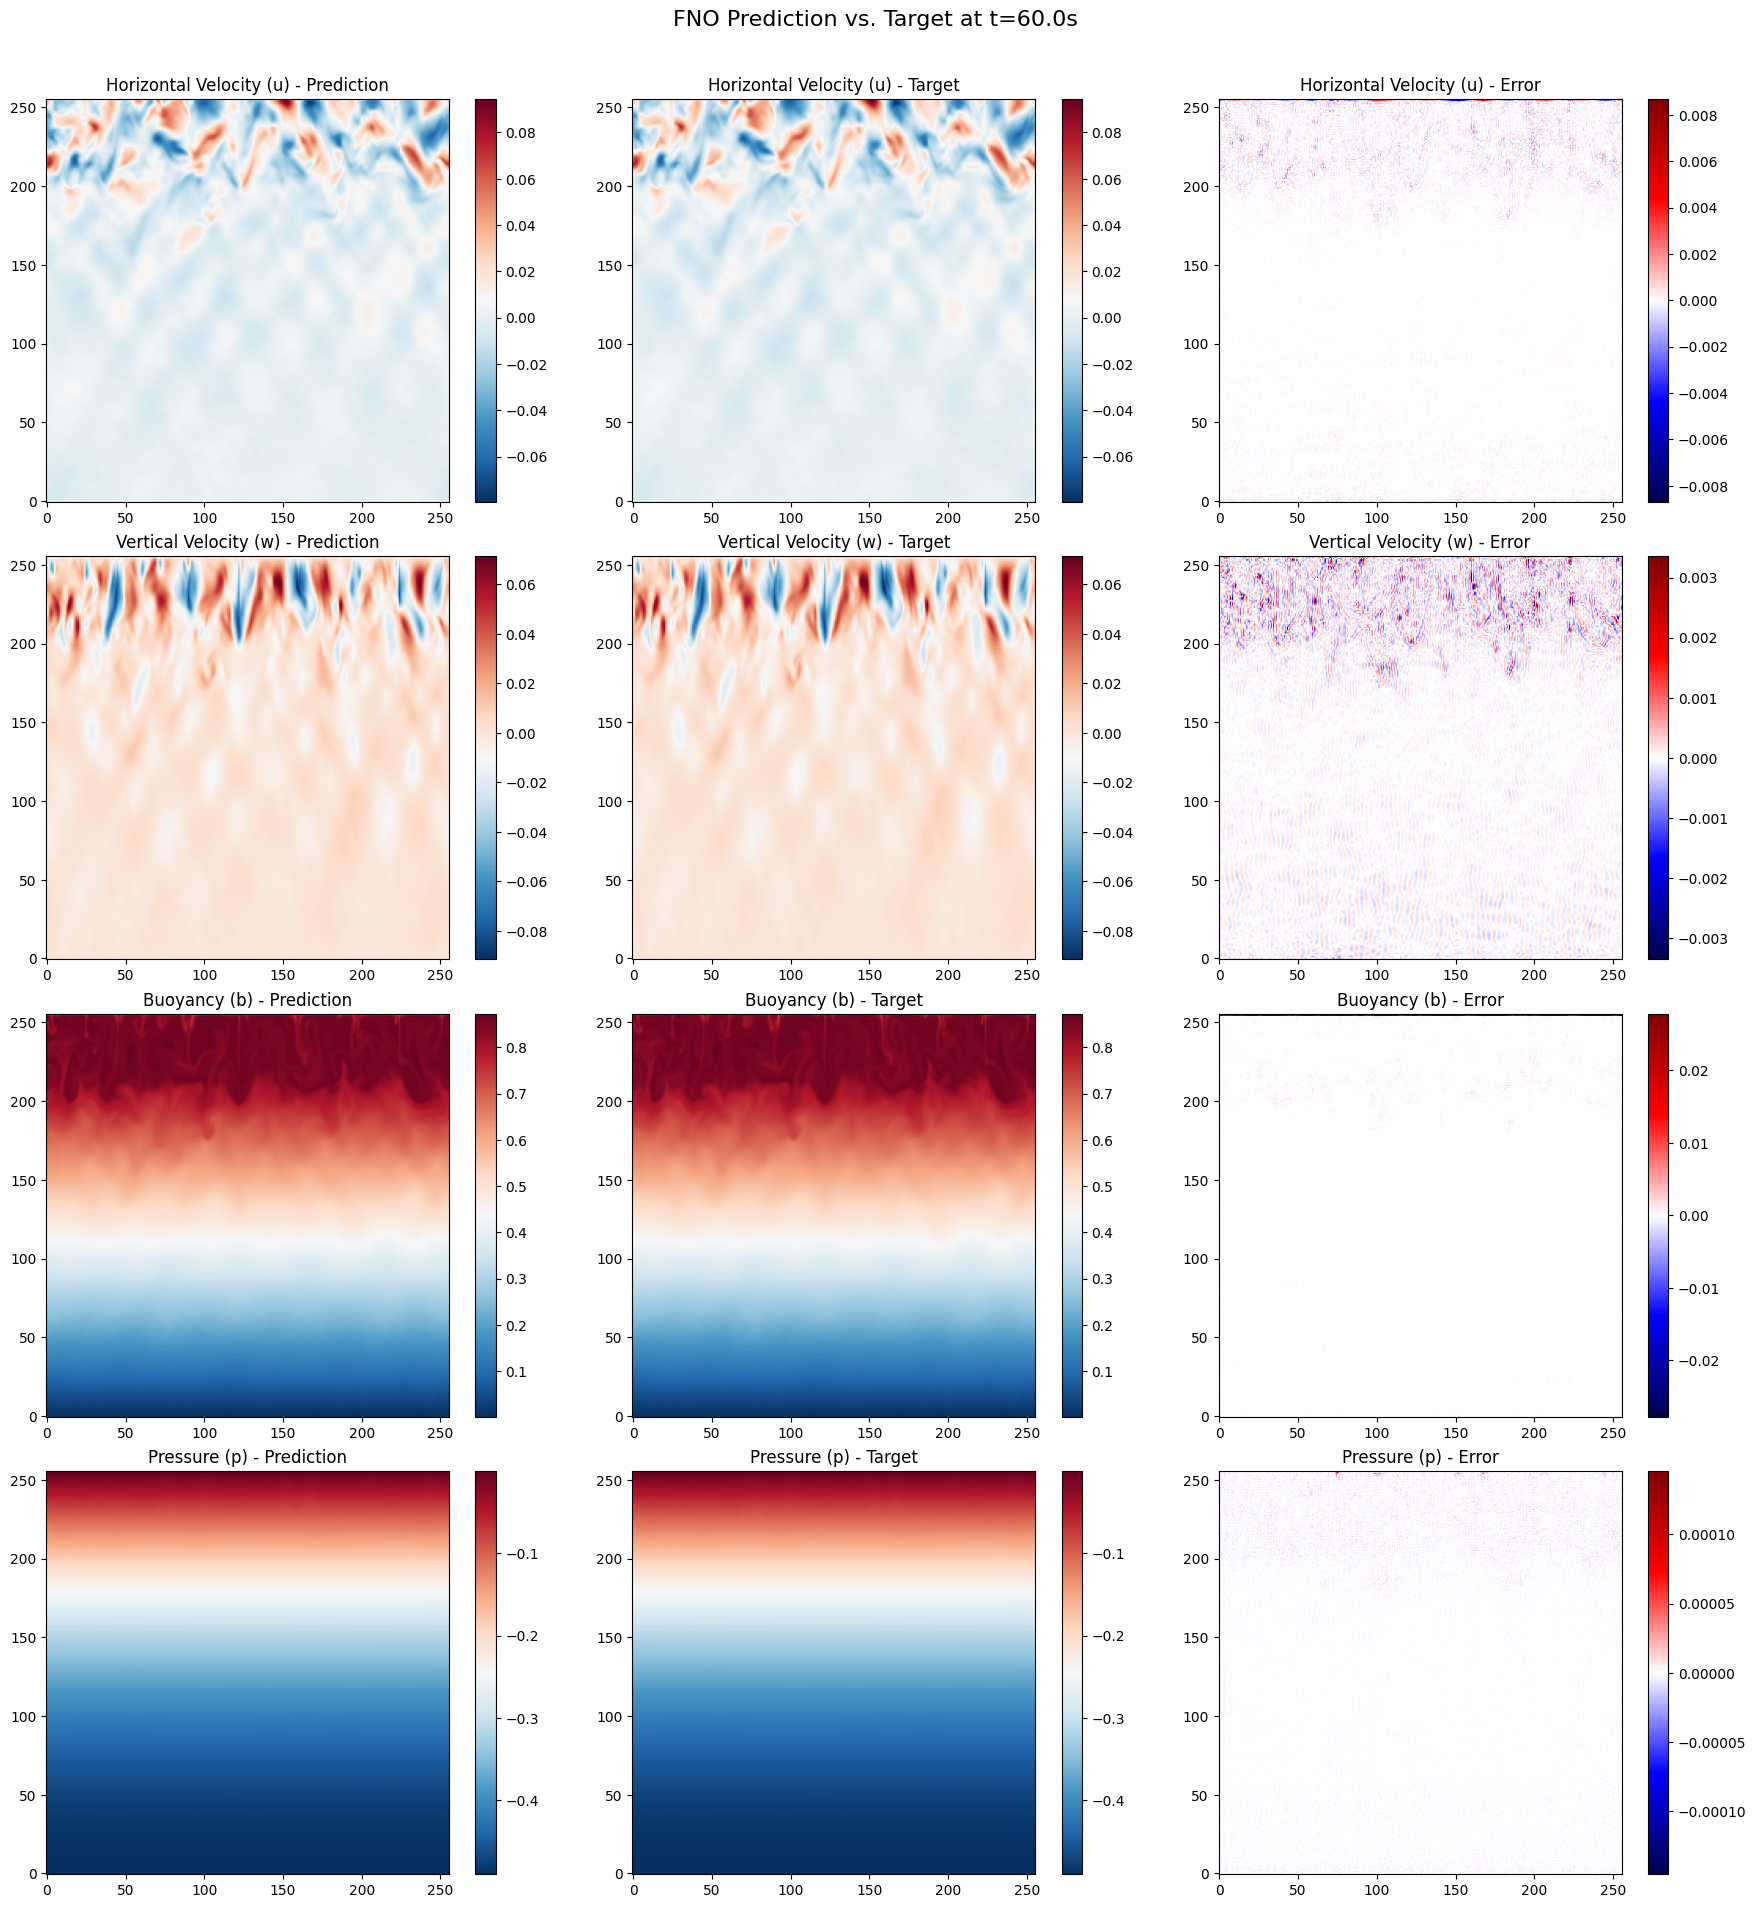

In [1]:
#==================================
# BLOCK 1 - Configuration and Setup
#==================================

import numpy as np
import torch
torch.cuda.empty_cache()
import torch.nn as nn
import torch.optim as optim
import xarray as xr
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.fft import rfft2, irfft2, fftfreq
import time

# --- CONFIGURATION DICTIONARY ---
# Change all experimental parameters here.
CONFIG = {
    'model': {
        'modes1': 32,
        'modes2': 32,
        'width': 64,
        'n_vars': 4,  # u, w, b, p
        'n_layers': 4,
    },
    'data': {
        'train_times': [30],  # Input time steps (indices)
        'target_time': 120,          # Target time step (index)
        'dt': 90.0,                  # Physical time difference between steps
    },
    'physics': {
        'kappa': 1e-6,
    },
    'training': {
        'epochs': 1600,
        'learning_rate': 1e-3,
        'weight_decay': 1e-4,
        'scheduler_pct_start': 0.1,
    },
    'loss_weights': {
        'physics': 1.0,
        'data': 10.0,
        'bc': 50.0,
        'smooth': 0.01
    }
}

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

#==================================
# BLOCK 2 - Core FNO Components
#==================================

class SpectralConv2d(nn.Module):
    """2D Fourier layer. Performs FFT, linear transform, and Inverse FFT."""
    
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels, self.out_channels, self.modes1, self.modes2 = in_channels, out_channels, modes1, modes2
        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        
    def compl_mul2d(self, input, weights):
        return torch.einsum("bixy,ioxy->boxy", input, weights)
    
    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = rfft2(x)
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)
        return irfft2(out_ft, s=(x.size(-2), x.size(-1)))

class FNOBlock(nn.Module):
    """Basic FNO block with spectral convolution and skip connection"""
    
    def __init__(self, in_channels, out_channels, modes1, modes2, activation='gelu'):
        super(FNOBlock, self).__init__()
        self.conv = SpectralConv2d(in_channels, out_channels, modes1, modes2)
        self.w = nn.Conv2d(in_channels, out_channels, 1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.GELU() if activation == 'gelu' else nn.ReLU()
    
    def forward(self, x):
        return self.activation(self.bn(self.conv(x) + self.w(x)))

#==================================
# BLOCK 3 - Multi-Variable FNO Model (Dynamically Configured)
#==================================

class MultiVariableFNO2d(nn.Module):
    """
    FNO for predicting multiple variables.
    The number of input channels is determined dynamically from the config.
    """
    
    def __init__(self, config):
        super(MultiVariableFNO2d, self).__init__()
        
        self.modes1 = config['model']['modes1']
        self.modes2 = config['model']['modes2']
        self.width = config['model']['width']
        self.n_vars = config['model']['n_vars']
        self.n_layers = config['model']['n_layers']
        
        # --- DYNAMIC CHANGE: Input channels depend on the length of train_times ---
        num_input_timesteps = len(config['data']['train_times'])
        in_channels = self.n_vars * num_input_timesteps
        
        self.fc0 = nn.Sequential(nn.Conv2d(in_channels, self.width, 1), nn.GELU(), nn.Conv2d(self.width, self.width, 1))
        self.fno_blocks = nn.ModuleList([FNOBlock(self.width, self.width, self.modes1, self.modes2) for _ in range(self.n_layers)])
        self.fc1 = nn.Sequential(nn.Conv2d(self.width, 128, 1), nn.GELU(), nn.Conv2d(128, 64, 1), nn.GELU(), nn.Conv2d(64, self.n_vars, 1))
        
    def forward(self, x):
        x = self.fc0(x)
        for fno in self.fno_blocks:
            x = fno(x)
        return self.fc1(x)

#==================================
# BLOCK 4 - Data Loading and Preprocessing
#==================================

# Load data
ds = xr.open_dataset('/kaggle/input/pr1-rbc-sim-data/RBC_Output.nc')

# Pull parameters from CONFIG
train_times = CONFIG['data']['train_times']
target_time = CONFIG['data']['target_time']
dt = CONFIG['data']['dt']
kappa = CONFIG['physics']['kappa']

def extract_fields_at_time(ds, time_idx):
    data = ds.isel(time=time_idx)
    return {'u': data['u'].values, 'w': data['w'].values, 'b': data['b'].values, 'p_dyn': data['p_dyn'].values}

def interpolate_w_to_centers(w_field):
    return 0.5 * (w_field[:-1, :] + w_field[1:, :])

def interpolate_to_common_grid(field, target_shape=(256, 256)):
    if field.shape == target_shape: return field
    return F.interpolate(torch.from_numpy(field).float().unsqueeze(0).unsqueeze(0), size=target_shape, mode='bilinear', align_corners=True).squeeze().numpy()

def normalize_field(field):
    mean, std = np.mean(field), np.std(field) + 1e-8
    return (field - mean) / std, mean, std

train_data = [extract_fields_at_time(ds, t) for t in train_times]
target_data = extract_fields_at_time(ds, target_time)

processed_train_data = []
norm_params = {'u': None, 'w': None, 'b': None, 'p': None, 'b_profile': None, 'p_profile': None}

for i, data in enumerate(train_data):
    w_centered = interpolate_w_to_centers(data['w'])
    u_interp = interpolate_to_common_grid(data['u'])
    b_interp = interpolate_to_common_grid(data['b'])
    p_interp = interpolate_to_common_grid(data['p_dyn'])
    
    b_profile = np.mean(b_interp, axis=1, keepdims=True)
    b_fluctuations = b_interp - b_profile
    p_profile = np.mean(p_interp, axis=1, keepdims=True)
    p_fluctuations = p_interp - p_profile
    
    if i == 0:
        u_norm, u_mean, u_std = normalize_field(u_interp)
        w_norm, w_mean, w_std = normalize_field(w_centered)
        b_norm, b_fluc_mean, b_fluc_std = normalize_field(b_fluctuations)
        p_norm, p_fluc_mean, p_fluc_std = normalize_field(p_fluctuations)
        norm_params.update({
            'u':(u_mean, u_std), 'w':(w_mean, w_std), 
            'b':(b_fluc_mean, b_fluc_std), 'p':(p_fluc_mean, p_fluc_std),
            'b_profile': b_profile, 'p_profile': p_profile
        })
    else:
        u_norm = (u_interp - norm_params['u'][0]) / norm_params['u'][1]
        w_norm = (w_centered - norm_params['w'][0]) / norm_params['w'][1]
        b_norm = (b_fluctuations - norm_params['b'][0]) / norm_params['b'][1]
        p_norm = (p_fluctuations - norm_params['p'][0]) / norm_params['p'][1]

    processed_train_data.append({'u': u_norm, 'w': w_norm, 'b': b_norm, 'p': p_norm})

target_b_interp = interpolate_to_common_grid(target_data['b'])
target_b_fluctuations = target_b_interp - norm_params['b_profile']
target_b_norm = (target_b_fluctuations - norm_params['b'][0]) / norm_params['b'][1]
target_p_interp = interpolate_to_common_grid(target_data['p_dyn'])
target_p_fluctuations = target_p_interp - norm_params['p_profile']
target_p_norm = (target_p_fluctuations - norm_params['p'][0]) / norm_params['p'][1]
target_w_centered = interpolate_w_to_centers(target_data['w'])
target_processed = {
    'u': (interpolate_to_common_grid(target_data['u']) - norm_params['u'][0]) / norm_params['u'][1],
    'w': (target_w_centered - norm_params['w'][0]) / norm_params['w'][1],
    'b': target_b_norm,
    'p': target_p_norm
}

input_channels = [d[k] for d in processed_train_data for k in ['u', 'w', 'b', 'p']]
input_tensor = torch.FloatTensor(np.stack(input_channels, axis=0)).unsqueeze(0).to(device)
target_tensor = torch.FloatTensor(np.stack([target_processed[k] for k in ['u', 'w', 'b', 'p']], axis=0)).unsqueeze(0).to(device)

print(f"Input tensor shape: {input_tensor.shape}")
print(f"Target tensor shape: {target_tensor.shape}")

x_coords, z_coords = ds.x_caa.values, ds.z_aac.values
dx, dz = float(x_coords[1] - x_coords[0]), float(z_coords[1] - z_coords[0])

#==================================
# BLOCK 5 - Physics-Informed Loss Functions
#==================================

def compute_derivatives_multi(fields, dx, dz):
    if fields.dim() == 3: fields = fields.unsqueeze(0)
    padded_x = F.pad(fields, (1, 1, 0, 0), mode='circular')
    df_dx = (padded_x[:, :, :, 2:] - padded_x[:, :, :, :-2]) / (2 * dx)
    df_dz = torch.zeros_like(fields)
    df_dz[:, :, 1:-1, :] = (fields[:, :, 2:, :] - fields[:, :, :-2, :]) / (2 * dz)
    df_dz[:, :, 0, :] = (fields[:, :, 1, :] - fields[:, :, 0, :]) / dz
    df_dz[:, :, -1, :] = (fields[:, :, -1, :] - fields[:, :, -2, :]) / dz
    return df_dx, df_dz

def physics_loss_multi(pred_norm, prev_states_norm, dx, dz, dt, kappa, norm_params):
    u_pred = pred_norm[:, 0] * norm_params['u'][1] + norm_params['u'][0]
    w_pred = pred_norm[:, 1] * norm_params['w'][1] + norm_params['w'][0]
    b_profile = torch.from_numpy(norm_params['b_profile']).float().to(device)
    b_pred_fluc = pred_norm[:, 2] * norm_params['b'][1] + norm_params['b'][0]
    b_pred = b_pred_fluc + b_profile
    p_profile = torch.from_numpy(norm_params['p_profile']).float().to(device)
    p_pred_fluc = pred_norm[:, 3] * norm_params['p'][1] + norm_params['p'][0]
    p_pred = p_pred_fluc + p_profile
    
    last_state = prev_states_norm[-1]
    u_last = torch.from_numpy(last_state['u']).float().to(device) * norm_params['u'][1] + norm_params['u'][0]
    w_last = torch.from_numpy(last_state['w']).float().to(device) * norm_params['w'][1] + norm_params['w'][0]
    b_last_fluc = torch.from_numpy(last_state['b']).float().to(device) * norm_params['b'][1] + norm_params['b'][0]
    b_last = b_last_fluc + b_profile
    
    all_fields = torch.stack([u_pred, w_pred, b_pred, p_pred], dim=1)
    df_dx, df_dz = compute_derivatives_multi(all_fields, dx, dz)
    
    du_dx, dw_dx, db_dx, dp_dx = [df_dx[:, i] for i in range(4)]
    du_dz, dw_dz, db_dz, dp_dz = [df_dz[:, i] for i in range(4)]
    
    d2u_dx2, _ = compute_derivatives_multi(du_dx.unsqueeze(1), dx, dz); _, d2u_dz2 = compute_derivatives_multi(du_dz.unsqueeze(1), dx, dz)
    d2w_dx2, _ = compute_derivatives_multi(dw_dx.unsqueeze(1), dx, dz); _, d2w_dz2 = compute_derivatives_multi(dw_dz.unsqueeze(1), dx, dz)
    d2b_dx2, _ = compute_derivatives_multi(db_dx.unsqueeze(1), dx, dz); _, d2b_dz2 = compute_derivatives_multi(db_dz.unsqueeze(1), dx, dz)
    
    du_dt, dw_dt, db_dt = (u_pred - u_last) / dt, (w_pred - w_last) / dt, (b_pred - b_last) / dt
    
    u_residual = du_dt + u_pred*du_dx.squeeze(1) + w_pred*du_dz.squeeze(1) + dp_dx.squeeze(1) - kappa*(d2u_dx2.squeeze(1) + d2u_dz2.squeeze(1))
    w_residual = dw_dt + u_pred*dw_dx.squeeze(1) + w_pred*dw_dz.squeeze(1) + dp_dz.squeeze(1) - kappa*(d2w_dx2.squeeze(1) + d2w_dz2.squeeze(1)) + b_pred
    continuity_residual = du_dx.squeeze(1) + dw_dz.squeeze(1)
    b_residual = db_dt + u_pred*db_dx.squeeze(1) + w_pred*db_dz.squeeze(1) - kappa*(d2b_dx2.squeeze(1) + d2b_dz2.squeeze(1))
    
    return torch.mean(u_residual**2) + torch.mean(w_residual**2) + torch.mean(continuity_residual**2) + torch.mean(b_residual**2)

def boundary_loss_multi(pred_norm, norm_params):
    u_pred = pred_norm[:, 0] * norm_params['u'][1] + norm_params['u'][0]
    w_pred = pred_norm[:, 1] * norm_params['w'][1] + norm_params['w'][0]
    b_profile = torch.from_numpy(norm_params['b_profile']).float().to(device)
    b_pred_fluc = pred_norm[:, 2] * norm_params['b'][1] + norm_params['b'][0]
    b_pred = b_pred_fluc + b_profile
    
    u_bc = torch.mean(u_pred[:, -1, :]**2) + torch.mean(u_pred[:, 0, :]**2)
    w_bc = torch.mean(w_pred[:, -1, :]**2) + torch.mean(w_pred[:, 0, :]**2)
    b_bc = torch.mean((b_pred[:, -1, :] - 0.5)**2) + torch.mean((b_pred[:, 0, :] - 0.0)**2)
    
    return u_bc + w_bc + b_bc

def smoothness_loss_multi(pred):
    tv_loss = 0
    for i in range(pred.shape[1]):
        field = pred[:, i]
        tv_loss += torch.mean(torch.abs(field[:, 1:, :] - field[:, :-1, :])) + torch.mean(torch.abs(field[:, :, 1:] - field[:, :, :-1]))
    return tv_loss

#==================================
# BLOCK 6 - Model Training and History Plotting
#==================================

# Initialize model using the CONFIG dictionary
model = MultiVariableFNO2d(config=CONFIG).to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters in FNO: {total_params:,}")

# Pull training params from CONFIG
optimizer = optim.AdamW(model.parameters(), lr=CONFIG['training']['learning_rate'], weight_decay=CONFIG['training']['weight_decay'])
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=CONFIG['training']['learning_rate'], epochs=CONFIG['training']['epochs'], steps_per_epoch=1, pct_start=CONFIG['training']['scheduler_pct_start'])
loss_weights = CONFIG['loss_weights']

history = {'total_loss': [], 'physics_loss': [], 'data_loss': [], 'bc_loss': [], 'smooth_loss': []}
model.train()
n_epochs = CONFIG['training']['epochs']
print_interval = 100
print("\nStarting training with dynamic configuration...")
best_loss = float('inf')
start_time = time.time()

for epoch in range(n_epochs):
    optimizer.zero_grad()
    pred_norm = model(input_tensor)
    
    # --- BUG FIX: Corrected the order of arguments in the function call ---
    l_physics = physics_loss_multi(pred_norm, processed_train_data, dx, dz, dt, kappa, norm_params)
    l_data = F.mse_loss(pred_norm, target_tensor)
    l_bc = boundary_loss_multi(pred_norm, norm_params)
    l_smooth = smoothness_loss_multi(pred_norm)
    
    total_loss = (loss_weights['physics'] * l_physics + 
                  loss_weights['data'] * l_data + 
                  loss_weights['bc'] * l_bc + 
                  loss_weights['smooth'] * l_smooth)
                  
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    
    for k, v in [('total', total_loss), ('physics', l_physics), ('data', l_data), ('bc', l_bc), ('smooth', l_smooth)]:
        history[k + '_loss'].append(v.item())
    
    if total_loss.item() < best_loss:
        best_loss = total_loss.item()
        best_model_state = model.state_dict().copy()
    
    if epoch % print_interval == 0 or epoch == n_epochs - 1:
        print(f"Epoch {epoch}/{n_epochs} | Total: {total_loss.item():.6f} | Physics: {l_physics.item():.6f} | Data: {l_data.item():.6f}")

print(f"\nTraining completed in {time.time() - start_time:.2f} seconds.")
model.load_state_dict(best_model_state)

# Plotting history
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
loss_names = ['total_loss', 'physics_loss', 'data_loss', 'bc_loss', 'smooth_loss']
for i, name in enumerate(loss_names):
    axes[i].semilogy(history[name])
    axes[i].set_title(name.replace('_', ' ').title())
    axes[i].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#==================================
# BLOCK 7 - Evaluation and Visualization
#==================================

model.eval()
with torch.no_grad():
    pred_norm = model(input_tensor).squeeze(0)
    
    u_pred = pred_norm[0].cpu().numpy() * norm_params['u'][1] + norm_params['u'][0]
    w_pred = pred_norm[1].cpu().numpy() * norm_params['w'][1] + norm_params['w'][0]
    
    b_pred_fluc = pred_norm[2].cpu().numpy() * norm_params['b'][1] + norm_params['b'][0]
    b_pred = b_pred_fluc + norm_params['b_profile']
    p_pred_fluc = pred_norm[3].cpu().numpy() * norm_params['p'][1] + norm_params['p'][0]
    p_pred = p_pred_fluc + norm_params['p_profile']

predictions = {'u': u_pred, 'w': w_pred, 'b': b_pred, 'p': p_pred}

targets = {
    'u': interpolate_to_common_grid(target_data['u']),
    'w': interpolate_w_to_centers(target_data['w']),
    'b': interpolate_to_common_grid(target_data['b']),
    'p': interpolate_to_common_grid(target_data['p_dyn'])
}

# Visualization
fig, axes = plt.subplots(4, 3, figsize=(18, 20))
fig.suptitle(f'FNO Prediction vs. Target at t={target_time*0.5}s', fontsize=16)
variables = ['u', 'w', 'b', 'p']
var_names = ['Horizontal Velocity (u)', 'Vertical Velocity (w)', 'Buoyancy (b)', 'Pressure (p)']

for i, (var, var_name) in enumerate(zip(variables, var_names)):
    pred, target = predictions[var], targets[var]
    
    vmin, vmax = min(pred.min(), target.min()), max(pred.max(), target.max())
    
    axes[i, 0].imshow(pred, aspect='equal', cmap='RdBu_r', vmin=vmin, vmax=vmax, origin='lower')
    axes[i, 0].set_title(f'{var_name} - Prediction')
    fig.colorbar(axes[i, 0].images[0], ax=axes[i, 0])
    
    axes[i, 1].imshow(target, aspect='equal', cmap='RdBu_r', vmin=vmin, vmax=vmax, origin='lower')
    axes[i, 1].set_title(f'{var_name} - Target')
    fig.colorbar(axes[i, 1].images[0], ax=axes[i, 1])
    
    diff = pred - target
    im3 = axes[i, 2].imshow(diff, aspect='equal', cmap='seismic', vmin=-np.abs(diff).max(), vmax=np.abs(diff).max(), origin='lower')
    axes[i, 2].set_title(f'{var_name} - Error')
    fig.colorbar(im3, ax=axes[i, 2])

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


torch.cuda.empty_cache()